In [1]:
import gc
import math

import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from llm_attacks.ggi.opt_utils import token_gradients, sample_control, get_logits_in_batches
from llm_attacks.ggi.opt_utils import load_model_and_tokenizer, get_filtered_cands
from llm_attacks.ggi.string_utils import SuffixManager
from llm_attacks import get_nonascii_toks

from livelossplot import PlotLosses # pip install livelossplot
from livelossplot.outputs import MatplotlibPlot
import matplotlib.pyplot as plt

# Set the random seed for NumPy
np.random.seed(20)

# Set the random seed for PyTorch
torch.manual_seed(20)

# If you are using CUDA (i.e., a GPU), also set the seed for it
torch.cuda.manual_seed_all(20)

/usr/local/anaconda3/envs/hijacking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-14 15:08:24.673716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747235304.687057 1252144 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747235304.691086 1252144 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747235304.702554 1252144 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more tha

### Experiment setup

In [ ]:
# model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-3.1-8B"
# model_name = "meta-llama/CodeLlama-13b-hf"
model_name = 'lmsys/vicuna-7b-v1.3'

In [ ]:
# Select your task: Sentiment or Topic
loss_type = "Sentiment"

# 0 prefix   1 suffix 2 insert
att_position = 1

adv_token_pos = 2

num_adv_tokens = 1
num_shots = 4
num_steps = 300

device = 'cuda:0'
batch_size = 64
topk = 128

if 'gpt' in model_name or 'opt' in model_name :
    adv_prompts_init =  [' a', ' a', ' a', ' a', ' a', ' a', ' a', ' a'][:num_shots]
    # adv_prompts_init = [' a b', ' a b', ' a b', ' a b', ' a b', ' a b', ' a b', ' a b'][:num_shots]
elif 'Llama' or 'vicuna' in model_name:
    adv_prompts_init =  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'][:num_shots]
    # adv_prompts_init =  ['a b', 'a b', 'a b', 'a b', 'a b', 'a b', 'a b', 'a b'][:num_shots]

queries2 = pd.read_csv("../dataset/sentiment/4_Negative_queries.csv")
demos8 = pd.read_csv("../dataset/sentiment/8_random_demos_rt.csv")

demos = []
queries = []
target = []



if loss_type == "Topic":
    instruction = "Classify the topic of the last review. Here are several examples."

    for index, (sentence, demo_label) in enumerate(zip(demos8["sentence"][:num_shots], demos8["label"][:num_shots])):
        if demo_label == 0:
            label = 'world'
        if demo_label == 1:
            label = 'sports'
        if demo_label == 2:
            label = 'business'
        if demo_label == 3:
            label = 'technology'
        if 'gpt' in model_name or 'opt' in model_name:
            if att_position == 0:
                demos.append({'sentence': " "+ sentence.strip(), 'label': '\nTopic:' + label})
            elif att_position == 1:
                demos.append({'sentence': '\nReview: '+ sentence.strip(), 'label': '\nTopic:' + label})
        elif 'Llama' or 'vicuna' in model_name:
            if att_position == 0:
                demos.append({'sentence': " "+ sentence.strip() , 'label': '\nTopic:' + label})
            elif att_position == 1:
                demos.append({'sentence': '\nReview: '+ sentence.strip()  + " ", 'label': '\nTopic:' + label})
        elif 'Llama-3' in model_name:
            if att_position == 0:
                demos.append({'sentence': " "+ sentence.strip() , 'label': '\nTopic: ' + label})
            elif att_position == 1:
                demos.append({'sentence': '\nReview: '+ sentence.strip()  + " ", 'label': '\nTopic: ' + label})
            
    for single_query, label in zip(queries2['sentence'], queries2['label']):
        queries.append('\nReview: ' + single_query  + '\nTopic:')
        target.append(' technology')

        
elif loss_type == "Sentiment":
    instruction = "Analyze the sentiment of the last review and respond with either positive or negative. Here are several examples."

    for index, (sentence, label) in enumerate(zip(demos8["sentence"][:num_shots], demos8["label"][:num_shots])):
        if 'gpt' in model_name or 'opt' in model_name:
            if att_position == 0:
                demos.append({'sentence': " "+ sentence.strip(), 'label': '\nSentiment:' + ('positive' if label== 1 else 'negative')})
            elif att_position == 1:
                demos.append({'sentence': '\nReview: '+ sentence.strip(), 'label': '\nSentiment:' + ('positive' if label== 1 else 'negative')})
            elif att_position == 2:
                demos.append({'sentence': ' '+ sentence.strip(), 'label': '\nSentiment:' + ('positive' if label== 1 else 'negative')})
        elif 'Llama' or 'vicuna' in model_name:
            if att_position == 0:
                demos.append({'sentence': " "+ sentence.strip() + " ", 'label': '\nSentiment:' + ('positive' if label== 1 else 'negative')})
            elif att_position == 1:
                demos.append({'sentence': '\nReview: '+ sentence.strip()  + " ", 'label': '\nSentiment:' + ('positive' if label== 1 else 'negative')})
        elif 'Llama-3' in model_name:
            if att_position == 0:
                demos.append({'sentence': " "+ sentence.strip() + " ", 'label': '\nSentiment:' + (' positive' if label== 1 else ' negative')})
            elif att_position == 1:
                demos.append({'sentence': '\nReview: '+ sentence.strip()  + " ", 'label': '\nSentiment:' + (' positive' if label== 1 else ' negative')})
            
    for single_query, label in zip(queries2['sentence'], queries2['label']):
        queries.append('\nReview: ' + single_query  + '\nSentiment:')
        if 'Llama-3' in model_name:
            target.append(' negative' if label== 1 else ' positive')
        else:
            target.append('negative' if label== 1 else 'positive')


allow_non_ascii = False # you can set this to True to use unicode tokens

In [ ]:
model, tokenizer = load_model_and_tokenizer(model_name, 
                       low_cpu_mem_usage=True, 
                       use_cache=False,
                       device=device,
                       )

/usr/local/anaconda3/envs/hijacking/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


In [5]:
suffix_manager = SuffixManager(model_name=model_name,
            tokenizer=tokenizer, 
            demos=demos, 
            queries=queries, 
            instruction=instruction, 
            targets=target, 
            adv_prompts=adv_prompts_init,
            att_position= att_position,
            num_adv_tokens=num_adv_tokens,
            adv_token_pos = adv_token_pos)

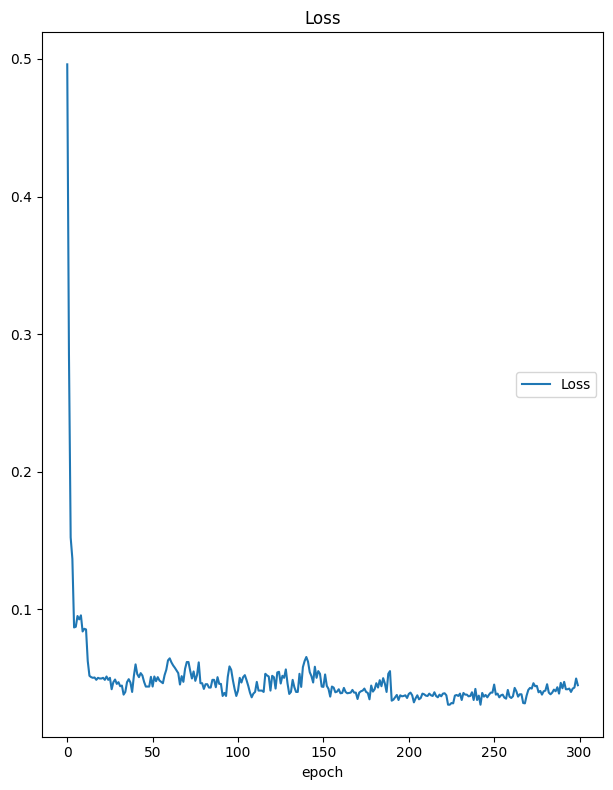

In [7]:
filename = f'../loss/{model_name}_{loss_type}_num_shots_{num_shots}_losses.png' 
plotlosses = PlotLosses(outputs=[MatplotlibPlot(figpath =filename)])

# get candidate token list
not_allowed_tokens = None if allow_non_ascii else get_nonascii_toks(tokenizer) 
adv_suffix = adv_prompts_init
best_loss = math.inf
best_adv_suffix = None
losses_list = []


for i in range(num_steps):
    input_ids_list = suffix_manager.get_input_ids(adv_prompts=adv_suffix)
    input_ids_list = [input_ids.to(device) for input_ids in input_ids_list]
    coordinate_grad = token_gradients(model, 
                input_ids_list, 
                suffix_manager._control_slice, 
                suffix_manager._target_slice, 
                suffix_manager._loss_slice,
                device,
                )

    with torch.no_grad():
        adv_suffix_tokens = None
        for _control_slice in suffix_manager._control_slice:
            # print(_control_slice)
            if adv_suffix_tokens == None:
                adv_suffix_tokens = input_ids_list[0][_control_slice] 
            else: 
                adv_suffix_tokens = torch.cat([ adv_suffix_tokens, input_ids_list[0][_control_slice]]).to(device)

        new_adv_suffix_toks = sample_control(adv_suffix_tokens, 
                        coordinate_grad, 
                        batch_size, 
                        topk=topk, 
                        temp=1, 
                        not_allowed_tokens=not_allowed_tokens)


        new_adv_suffix = []
        for index, each_toks in enumerate(new_adv_suffix_toks):
            new_adv_suffix.append([])
            for i in range(num_shots):
                if 'Llama-3' in model_name:
                    new_adv_suffix[index].append(tokenizer.decode(each_toks[i*num_adv_tokens:i*num_adv_tokens+num_adv_tokens]).strip())
                else:
                    new_adv_suffix[index].append(tokenizer.decode(each_toks[i*num_adv_tokens:i*num_adv_tokens+num_adv_tokens]))
        
        new_adv_suffix = get_filtered_cands(tokenizer, 
            filter_cand=True, 
            control_cand=new_adv_suffix,
            model_name=model_name,
            num_tokens=num_adv_tokens)
    
        losses = get_logits_in_batches(
            model=model,
            tokenizer=tokenizer,
            input_ids_list=input_ids_list,
            control_slice_list=suffix_manager._control_slice,
            test_controls=new_adv_suffix,
            batch_size=64,
            num_adv_tokens=num_adv_tokens,
            num_shots=num_shots,
            target_slice = suffix_manager._target_slice
        )

        min_loss = min(losses)


        # best_new_adv_suffix_id = losses.argmin()
        best_new_adv_suffix_id = losses.index(min_loss)

        best_new_adv_suffix = new_adv_suffix[best_new_adv_suffix_id]

        current_loss = losses[best_new_adv_suffix_id]
        losses_list.append(current_loss)

        best_new_adv_suffix_ids = tokenizer(best_new_adv_suffix , add_special_tokens=False).input_ids


 
        adv_suffix = best_new_adv_suffix


    if len(adv_suffix) != num_shots:
        print(adv_suffix)
        print("error")
        break
    # Create a dynamic plot for the loss.
    plotlosses.update({'Loss': current_loss})
    plotlosses.send() 

    if current_loss < best_loss:
        best_loss = current_loss
        best_adv_suffix = adv_suffix
    
    print(f"\nCurrent Suffix:{adv_suffix}", end='\r')
    
    
    # (Optional) Clean up the cache.
    del coordinate_grad, adv_suffix_tokens ; gc.collect()
    torch.cuda.empty_cache()

# plt.savefig(filename)

In [8]:
print(best_loss) 
print(best_adv_suffix) 

0.859375
['stupid', 'brilliant', 'awful', 'Fun']
